In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import neighbors
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE

In [171]:
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_test = MinMaxScaler(feature_range=(0, 1))
train_data = pd.read_csv('../Auto Pipeline/10_weekly_train.csv')
test_data = pd.read_csv('../Auto Pipeline/10_weekly_test.csv')
train_data.drop(["Date"],1, inplace = True)
test_data.drop(["Date"],1, inplace = True)

In [172]:
train_mov = train_data["movement"]
test_mov = test_data["movement"]
col_name = train_data.drop(["Close (t)","movement"],1).columns
train = train_data.copy()
test = test_data.copy()
train[col_name] = scaler_x.fit_transform(train_data.drop(["Close (t)","movement"],1))
label_train = pd.Series(scaler_y.fit_transform(train_data[["Close (t)"]]).reshape(-1))
test[col_name] = scaler_x.fit_transform(test_data.drop(["Close (t)","movement"],1))
scaled_test = pd.Series(scaler_test.fit_transform(test_data[["Close (t)"]]).reshape(-1))
label_test = test_data["Close (t)"]

In [173]:
def evaluate(test, label_test):
    predicted = test
    print("accuracy:", str(accuracy_score(label_test, predicted)))
    
    print("precision:", str(precision_score(label_test, predicted, average='weighted')))

    print("recall:", str(recall_score(label_test, predicted, average='weighted')))
   
    print("f1", str(f1_score(label_test, predicted, average='weighted')))
    
    print("metrics.roc_auc_score", str(roc_auc_score(label_test, predicted, average='weighted')))

    cm = confusion_matrix(label_test, predicted)
    f = sns.heatmap(cm, annot=True, fmt='d')
    
    classification = classification_report(label_test, predicted)
    print(classification)


In [174]:
knn = neighbors.KNeighborsRegressor(n_neighbors = 181, metric='euclidean')
knn_model = knn.fit(train, label_train)


In [175]:
print('kNN R-squared for training set: %f' % knn_model.score(train, label_train))
print('kNN R-squared for test set: %f' % knn_model.score(test, scaled_test))

ypred = knn_model.predict(test)
ypred = scaler_test.inverse_transform(ypred.reshape(-1,1))
ypred = ypred.reshape(-1)

print('kNN MAE for test set: %f' % mean_absolute_error(label_test, ypred))
print('kNN MSE for test set: %f' % mean_squared_error(label_test, ypred, squared=True))
print('kNN RMSE for test set: %f' % mean_squared_error(label_test, ypred, squared=False))


kNN R-squared for training set: 0.976631
kNN R-squared for test set: 0.784766
kNN MAE for test set: 176.897555
kNN MSE for test set: 40318.862140
kNN RMSE for test set: 200.795573


In [176]:

#Obtain new train movement label based on whether ypred close price at t > close price at t-1
ypred_train = knn_model.predict(train)
ypred_train = scaler_y.inverse_transform(ypred_train.reshape(-1,1))
ypred_train = ypred_train.reshape(-1)
train_move = (ypred_train - train_data["Close (t-1)"])
train_move = train_move.where(train_move < 0, 1).where(train_move >= 0, 0).astype(int)
label_train_move = train_data["movement"]
test_move = (ypred - test_data["Close (t-1)"])
test_move = test_move.where(test_move < 0, 1).where(test_move >= 0, 0).astype(int)
label_test_move = test_data["movement"]


accuracy: 0.5918079096045198
precision: 0.5419300516481799
recall: 0.5918079096045198
f1 0.5256428814943197
metrics.roc_auc_score 0.5097081671215621
              precision    recall  f1-score   support

           0       0.42      0.14      0.21       275
           1       0.62      0.88      0.72       433

    accuracy                           0.59       708
   macro avg       0.52      0.51      0.47       708
weighted avg       0.54      0.59      0.53       708



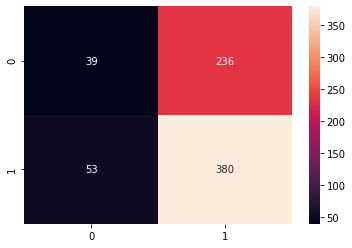

In [177]:
metric_test = evaluate(test_move, label_test_move)

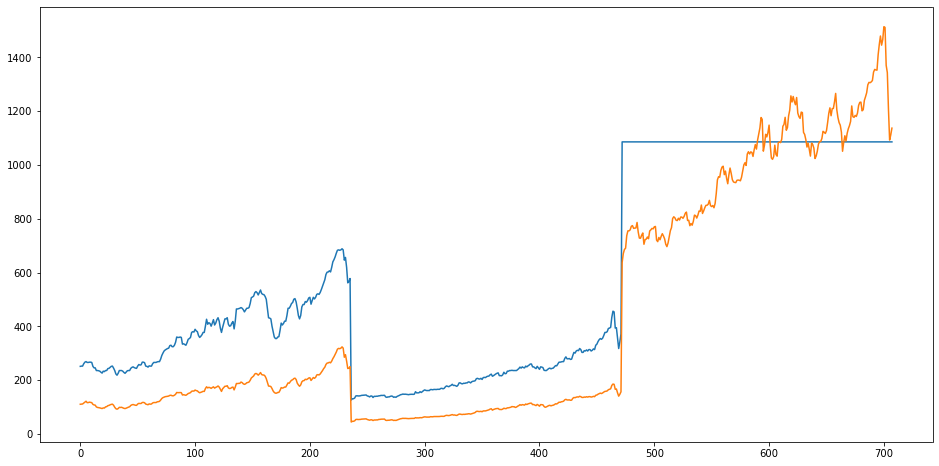

In [178]:
plt.figure(figsize=(16,8))
plt.plot(ypred)
plt.plot(label_test)